In [52]:
import os, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.utils.data import Dataset, DataLoader
import random
from typing import List, Tuple, Dict, Iterable
from torch_geometric.data import Batch

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)
rng = np.random.default_rng(7)

# Config 

In [54]:
@dataclass
class SimCfg:
    R: float = 200.0
    P_max: float = 200.0
    S_L: float = 1.0
    S_W: float = 0.75
    c_price: float = 0.1
    B: float = 10**6
    n0: float = None         
    Fs: int = 3                
    K: int = 3             
    N: int = 5

In [55]:
def pathloss_gain(d):
    return -(120.9 + 37.6 * np.log10(d / 1000.0)) + 7 * np.random.normal(1, size=d.shape)

In [56]:
def calculate_channel_matrix(distances, is_bs: bool):
    d = distances.reshape(-1, 1) if is_bs else distances
    pathloss = pathloss_gain(d)
    small_scale = np.random.normal(1, size=d.shape) ** 2
    channel_gain = 10 ** (pathloss / 10.0) * small_scale
    return np.abs(channel_gain).astype(np.float32)

In [57]:
class StandardScalerNP:
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = X.mean(0)
        self.std_ = X.std(0)
        self.std_[self.std_==0]=1.0
    def transform(self, X): return (X-self.mean_)/self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

# Generate dataset 

In [58]:
# # -------------------------------
# # Environment Setup
# # -------------------------------
# R = 200
# P_max = 200
# S_L = 1         # LTE satisfaction per unit rate
# S_W = 0.75      # WiFi satisfaction per unit rate



# c = 0.1         # Cost per unit data rate
# B = 10**6       # Bandwidth
# n0 = B * 10**-17.4  # Noise power

# F = 3          # Number of subchannels
# K = 3           # Number of WiFi APs
# N = 5           # Number of users

# bs_location = np.array([R, R])
# user_locations = []
# ap_locations = []
# C_i = []         # User affordability
# L_thr = []       # Satisfaction thresholds

# # Random affordability for 40% of users
# selected_users = set(random.sample(range(N), int(N * 0.4)))

# for i in range(N):
#     L_thr.append(0.3)
#     x, y = np.random.uniform(0, 2 * R, size=2)
#     user_locations.append([x, y])
#     C = np.random.uniform(5, 10) if i in selected_users else 0
#     C_i.append(C)

# for i in range(K):
#     x, y = np.random.uniform(0, 2 * R, size=2)
#     ap_locations.append([x, y])

# user_locations = np.array(user_locations)
# ap_locations = np.array(ap_locations)

# # -------------------------------
# # Channel Calculation
# # -------------------------------

# def calculate_channel_matrix(distances, is_bs):
#     if is_bs:
#         distances = distances.reshape(-1, 1)
#     pathloss = -(120.9 + 37.6 * np.log10(distances / 1000)) + \
#                7 * np.random.normal(1, size=distances.shape)
#     small_scale = np.random.normal(1, size=distances.shape)**2
#     channel_gain = 10 ** (pathloss / 10) * small_scale
#     return np.abs(channel_gain)

# d_user_ap = np.linalg.norm(user_locations[:, None] - ap_locations, axis=2)
# d_user_bs = np.linalg.norm(user_locations - bs_location, axis=1)
# h_ik = calculate_channel_matrix(d_user_ap, is_bs=False)
# h_iL = calculate_channel_matrix(d_user_bs, is_bs=True).flatten()

# # -------------------------------
# # Random Fixed Assignments: X, Ψ, q
# # -------------------------------

# X_iL = np.zeros(N)
# X_ik = np.zeros((N, K))
# Psi = np.zeros((N, F))
# q = np.random.randint(0, 2, N)  # Random satisfaction indicator

# for i in range(N):
#     sel = np.random.choice(K + 1)
#     if sel == K:
#         X_iL[i] = 1
#     else:
#         X_ik[i, sel] = 1
#     Psi[i, np.random.choice(F)] = 1

In [59]:
def generate_dataset(cfg: SimCfg, seed: int = 7, standardize: bool = True):
    random.seed(seed)
    n0 = cfg.B * 10**-17.4 if (cfg.n0 is None) else cfg.n0
    bs_location = np.array([cfg.R, cfg.R], dtype=np.float32)

    user_locations, ap_locations = [], []
    C_i, L_thr = [], []

    # Random affordability for 40% of users
    selected_users = set(random.sample(range(cfg.N), max(1, int(cfg.N * 0.4))))

    for i in range(cfg.N):
        L_thr.append(0.3)
        x, y = np.random.uniform(0, 2 * cfg.R, size=2)
        user_locations.append([x, y])
        C = np.random.uniform(5, 10) if i in selected_users else 0.0
        C_i.append(C)

    for i in range(cfg.K):
        x, y = np.random.uniform(0, 2 * cfg.R, size=2)
        ap_locations.append([x, y])

    user_locations = np.array(user_locations, dtype=np.float32)
    ap_locations   = np.array(ap_locations,   dtype=np.float32)
    C_i  = np.array(C_i,  dtype=np.float32)
    L_thr= np.array(L_thr,dtype=np.float32)

    # -------------------------------
    # Channel Calculation
    # -------------------------------

    d_user_ap = np.linalg.norm(user_locations[:, None] - ap_locations[None, :], axis=2)  # (N,K)
    d_user_bs = np.linalg.norm(user_locations - bs_location, axis=1)                     # (N,)
    h_ik = calculate_channel_matrix(d_user_ap, is_bs=False)                               # (N,K)
    h_iL = calculate_channel_matrix(d_user_bs, is_bs=True).flatten()                      # (N,)

    # -------------------------------
    # Random Fixed Assignments: X, Ψ, q
    # -------------------------------
    X_iL = np.zeros(cfg.N, dtype=np.int64)
    X_ik = np.zeros((cfg.N, cfg.K), dtype=np.int64)
    Psi  = np.zeros((cfg.N, cfg.Fs), dtype=np.int64)
    q    = np.random.randint(0, 2, cfg.N).astype(np.int64)  # Random satisfaction indicator

    subband_idx = np.zeros(cfg.N, dtype=np.int64)
    ap_idx      = -np.ones(cfg.N, dtype=np.int64)  # -1 nếu LTE

    for i in range(cfg.N):
        sel = np.random.choice(cfg.K + 1)  # {0..K-1}=AP, K=LTE
        if sel == cfg.K:
            X_iL[i] = 1
            ap_idx[i] = -1
        else:
            X_ik[i, sel] = 1
            ap_idx[i] = sel
        f = np.random.choice(cfg.Fs)
        Psi[i, f] = 1
        subband_idx[i] = f

    # -------------------------------
    # Interference matrix Hbar
    Hbar = np.zeros((cfg.N, cfg.N), dtype=np.float32)
    for i in range(cfg.N):
        if X_iL[i] == 1:
            Hbar[i, :] = h_iL[:]
        else:
            kstar = ap_idx[i]
            Hbar[i, :] = h_ik[:, kstar]
    np.fill_diagonal(Hbar, 0.0)

    # -------------------------------
    # Build graph edges
    # -------------------------------
    P_vec = np.full(cfg.N, cfg.P_max, dtype=np.float32)  # nếu muốn power cá nhân, thay ở đây
    edge_src, edge_dst, edge_w = [], [], []
    for f in range(cfg.Fs):
        ids = np.where(subband_idx == f)[0]
        if ids.size <= 1:
            continue
        for a in ids:
            for b in ids:
                if a == b: 
                    continue
                w = P_vec[b] * Hbar[a, b]
                edge_src.append(a); edge_dst.append(b); edge_w.append(float(w))

    edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
    edge_weight = torch.tensor(edge_w, dtype=torch.float32)


    feat_cols = ["Pmax", "Ci", "Lthr", "h_iL"] + [f"h_i{k}" for k in range(cfg.K)]
    df = pd.DataFrame({
        "Pmax": np.full(cfg.N, cfg.P_max, dtype=np.float32),
        "Ci":   C_i,
        "Lthr": L_thr,
        "h_iL": h_iL
    })
    for k in range(cfg.K):
        df[f"h_i{k}"] = h_ik[:, k]
    df["subband"] = subband_idx
    df["x_LTE"]   = X_iL
    df["ap_idx"]  = ap_idx
    df["q"]       = q

    X_np = df[feat_cols].to_numpy(np.float32)
    if standardize:
        X_mean = X_np.mean(axis=0); X_std = X_np.std(axis=0); X_std[X_std == 0] = 1.0
        X_np = (X_np - X_mean) / X_std

    data = Data(
        x=torch.tensor(X_np, dtype=torch.float32),
        edge_index=edge_index,
        edge_weight=edge_weight
    )

    aux = {
        "g_iL": torch.tensor(h_iL, dtype=torch.float32),
        "g_ik": torch.tensor(h_ik, dtype=torch.float32),
        "Pmax": torch.tensor(np.full(cfg.N, cfg.P_max, dtype=np.float32), dtype=torch.float32),
        "Ci":   torch.tensor(C_i, dtype=torch.float32),
        "Lthr": torch.tensor(L_thr, dtype=torch.float32),
        "noise": torch.tensor(float(n0), dtype=torch.float32),
        "SL": torch.tensor(float(cfg.S_L), dtype=torch.float32),
        "SW": torch.tensor(float(cfg.S_W), dtype=torch.float32),
        "cprice": torch.tensor(float(cfg.c_price), dtype=torch.float32),
        "N": cfg.N, "K": cfg.K, "F": cfg.Fs,
        "X_iL": torch.tensor(X_iL, dtype=torch.int64),
        "X_ik": torch.tensor(X_ik, dtype=torch.int64),
        "Psi":  torch.tensor(Psi,  dtype=torch.int64),
        "q":    torch.tensor(q,    dtype=torch.int64),
        "subband_idx": torch.tensor(subband_idx, dtype=torch.int64),
        "ap_idx":      torch.tensor(ap_idx,      dtype=torch.int64),
        "user_xy": torch.tensor(user_locations, dtype=torch.float32),
        "ap_xy":   torch.tensor(ap_locations,   dtype=torch.float32),
        "bs_xy":   torch.tensor([cfg.R, cfg.R], dtype=torch.float32)
    }

    return df, data, aux


In [60]:
def generate_scenarios(cfg, num_scenarios: int, start_seed: int = 7) \
        -> List[Tuple['pd.DataFrame','Data',Dict]]:
    scenarios = []
    for i in range(num_scenarios):
        seed = start_seed + i
        df_i, data_i, aux_i = generate_dataset(cfg, seed=seed)  
        df_i["scenario_id"] = i
        aux_i["scenario_id"] = i
        scenarios.append((df_i, data_i, aux_i))
    return scenarios

def build_scenario_batches(
    cfg,
    num_scenarios: int,
    batch_size: int = 64,
    start_seed: int = 7,
    device: 'torch.device' = None,
    shuffle: bool = True,
) -> Iterable[Tuple['Batch', List[Dict]]]:
    if device is None:
        import torch
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    scenarios = generate_scenarios(cfg, num_scenarios=num_scenarios, start_seed=start_seed)
    if shuffle:
        random.shuffle(scenarios)
    for start in range(0, len(scenarios), batch_size):
        chunk = scenarios[start:start+batch_size]
        data_list = [d.to(device) for (_, d, _) in chunk]
        aux_list  = [a for (_, _, a) in chunk]    
        batch = Batch.from_data_list(data_list)   
        yield batch, aux_list

In [61]:
def build_fixed_batches(cfg, num_scenarios=1000, batch_size=64, start_seed=7):
    scenarios = []
    for i in range(num_scenarios):
        seed = start_seed + i
        df_i, data_i, aux_i = generate_dataset(cfg, seed=seed)
        scenarios.append((df_i, data_i, aux_i))

    batches = []
    for start in range(0, len(scenarios), batch_size):
        chunk = scenarios[start:start+batch_size]
        data_list = [d for (_, d, _) in chunk]
        aux_list  = [a for (_, _, a) in chunk]
        batched = Batch.from_data_list(data_list)     
        batches.append((batched, aux_list))

    return batches

In [62]:
cfg = SimCfg(R=200, P_max=200, S_L=1.0, S_W=0.75, c_price=0.1, B=10**6, n0=None, Fs=3, K=3, N=5)
batches = build_fixed_batches(cfg, num_scenarios=1000, batch_size=64, start_seed=7)
print(f"Số batch cố định: {len(batches)}  (batch cuối có thể nhỏ hơn 64)")


Số batch cố định: 16  (batch cuối có thể nhỏ hơn 64)


# Policy-GCN

In [63]:
class PolicyGCN(nn.Module):
    def __init__(self, in_dim, hidden, K, Fs):
        super().__init__()
        #embedding
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        # outputs:
        self.recv_head = nn.Linear(hidden, K+1)  # [LTE | AP1..APK]
        self.band_head = nn.Linear(hidden, Fs)    # subband logits
        self.pow_head  = nn.Linear(hidden, 1)    # power logit -> sigmoid

    def forward(self, x, edge_index, edge_weight=None):
        h = self.conv1(x, edge_index, edge_weight=edge_weight)
        h = F.relu(h)
        h = self.conv2(h, edge_index, edge_weight=edge_weight)
        h = F.relu(h)
        recv_logits = self.recv_head(h)          # (N, K+1)
        band_logits = self.band_head(h)          # (N, F)
        pow_logit   = self.pow_head(h).squeeze(-1)  # (N,)
        w_rx = F.softmax(recv_logits, dim=-1)    # (N, K+1)
        p_f  = F.softmax(band_logits, dim=-1)    # (N, F)
        a    = torch.sigmoid(pow_logit)          # (N,)
        return w_rx, p_f, a

In [64]:
model = PolicyGCN(in_dim=7, hidden=256, K=cfg.K, Fs=cfg.Fs).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-3)

# Differentiable objective: maximize total satisfaction

In [65]:
def objective_total_satisfaction(w_rx, p_f, a, aux):
    """
    w_rx: (N, K+1)  -> wL = [:,0], wW = [:,1:]
    p_f:  (N, F)    -> per-user subband soft assignment
    a:    (N,)      -> power fraction in [0,1]
    Returns: (mean_L, penalties_dict)
    """
    g_iL = aux["g_iL"]    # (N,)
    g_ik = aux["g_ik"]    # (N,K)
    Pmax = aux["Pmax"]    # (N,)
    Ci   = aux["Ci"]      # (N,)
    Lthr = aux["Lthr"]    # (N,)
    noise = aux["noise"]  # scalar
    SL, SW = aux["SL"], aux["SW"]
    cprice = aux["cprice"]
    N, K, Fs = aux["N"], g_ik.size(1), p_f.size(1)

    wL = w_rx[:, 0]         # (N,)
    wW = w_rx[:, 1:]        # (N,K)

    # desired gain for user i: h_des[i]
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                # (N,)

    # interference matrix Hbar_soft: H[i,j] = wL[i]*g_L[j] + sum_k wW[i,k]*g_ik[j,k]
    term1 = wL.unsqueeze(1) * g_iL.unsqueeze(0)               # (N,N)
    term2 = wW @ g_ik.transpose(0,1)                          # (N,N)
    Hbar = term1 + term2
    Hbar.fill_diagonal_(0.0)

    # transmit power
    P = a * Pmax                                              # (N,)

    # SINR_i = sum_f p_if * (P_i*h_des[i]) / (sum_j p_jf * P_j * Hbar[i,j] + noise)
    num = P * h_des                                           # (N,)
    SINR = torch.zeros_like(num)
    for f in range(Fs):
        S_f = p_f[:, f] * P                                   # (N,)
        denom = Hbar @ S_f + noise                            # (N,)
        SINR = SINR + p_f[:, f] * (num / (denom + 1e-30))
    rate = torch.log2(1.0 + SINR)                             # (N,)

    # Satisfaction
    S_i = SW + (SL - SW) * wL                                 # (N,)
    L_i = S_i * rate                                          # (N,)

    mean_L = L_i.mean()

    # Penalties:
    # Budget (LTE): c * r_i * wL <= Ci  -> relu(c*r_i*wL - Ci)
    budget_violation = F.relu(cprice * rate * wL - Ci).mean()

    # QoS: L_i >= Lthr  -> relu(Lthr - L_i)
    qos_violation = F.relu(Lthr - L_i).mean()

    penalties = {
        "budget": budget_violation,
        "qos": qos_violation
    }
    return mean_L, penalties

In [66]:
def train_one_epoch(policy, batches, optimizer,
                    lambda_budget=1.0, lambda_qos=1.0,
                    objective_fn=None, clip_grad=None, verbose=False):
    if objective_fn is None:
        objective_fn = objective_total_satisfaction

    device = next(policy.parameters()).device
    policy.train()
    epoch_loss = epoch_meanL = epoch_budget = epoch_qos = 0.0
    num_batches = 0

    for batch, aux_list in batches:
        batch = batch.to(device)        
        optimizer.zero_grad()

        w_rx, p_f, a = policy(batch.x, batch.edge_index, batch.edge_weight)
        ptr = batch.ptr.detach().cpu().numpy()

        loss_list, meanL_list, budget_list, qos_list = [], [], [], []
        for s_idx in range(len(aux_list)):
            lo, hi = int(ptr[s_idx]), int(ptr[s_idx+1])
            w_rx_i, p_f_i, a_i = w_rx[lo:hi], p_f[lo:hi], a[lo:hi]

            # move aux_i sang device (aux lưu CPU là đúng)
            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in aux_list[s_idx].items()}
            aux_i["N"] = hi - lo

            mean_L, pens = objective_fn(w_rx_i, p_f_i, a_i, aux_i)
            loss_i = -mean_L + lambda_budget * pens["budget"] + lambda_qos * pens["qos"]

            loss_list.append(loss_i)
            meanL_list.append(mean_L)
            budget_list.append(pens["budget"])
            qos_list.append(pens["qos"])

        loss_batch   = torch.stack(loss_list).mean()
        meanL_batch  = torch.stack(meanL_list).mean()
        budget_batch = torch.stack(budget_list).mean()
        qos_batch    = torch.stack(qos_list).mean()

        loss_batch.backward()
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(policy.parameters(), clip_grad)
        optimizer.step()

        epoch_loss   += float(loss_batch.item())
        epoch_meanL  += float(meanL_batch.item())
        epoch_budget += float(budget_batch.item())
        epoch_qos    += float(qos_batch.item())
        num_batches  += 1

        if verbose:
            print(f"  batch {num_batches:03d} | loss {loss_batch.item():.4f}")

    return {
        "loss":   epoch_loss / max(num_batches, 1),
        "meanL":  epoch_meanL / max(num_batches, 1),
        "budget": epoch_budget / max(num_batches, 1),
        "qos":    epoch_qos / max(num_batches, 1),
        "batches": num_batches,
    }

In [67]:
EPOCHS = 3
logs = []
for ep in range(1, EPOCHS+1):
    loader = build_scenario_batches(cfg, num_scenarios=640, batch_size=64,
                                    start_seed=7+ep, device=device, shuffle=True)
    log = train_one_epoch(model, batches, opt,
                          lambda_budget=1.0, lambda_qos=1.0,
                          objective_fn=objective_total_satisfaction,
                          clip_grad=None, verbose=False)
    logs.append(log)
    print(f"[Epoch {ep:03d}] loss {log['loss']:.4f} | meanL {log['meanL']:.4f} "
          f"| budget {log['budget']:.4f} | qos {log['qos']:.4f} | batches {log['batches']}")

[Epoch 001] loss -1.2030 | meanL 1.3708 | budget 0.0432 | qos 0.1246 | batches 16
[Epoch 002] loss -4.0767 | meanL 4.2955 | budget 0.1318 | qos 0.0869 | batches 16
[Epoch 003] loss -7.8703 | meanL 8.2286 | budget 0.2552 | qos 0.1031 | batches 16


# Evaluate performance 

## Convergence

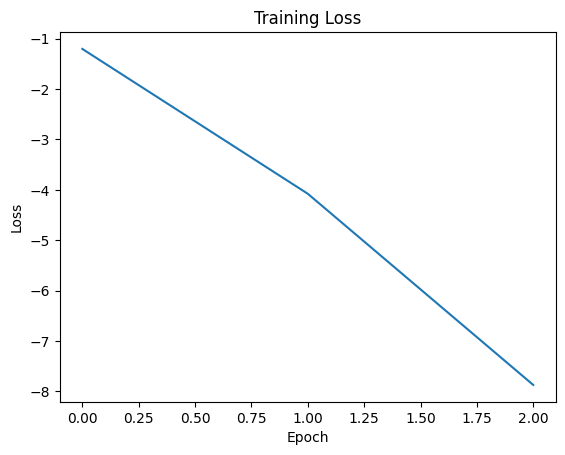

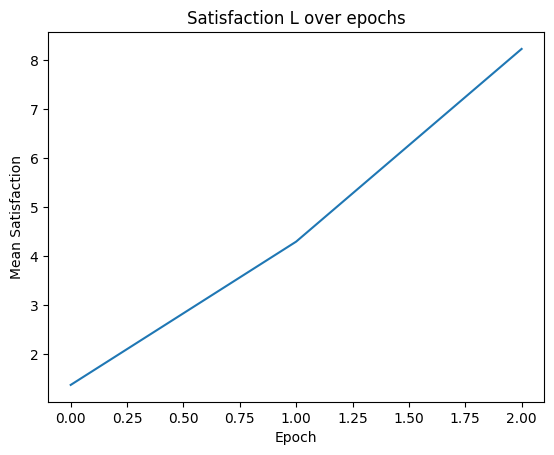

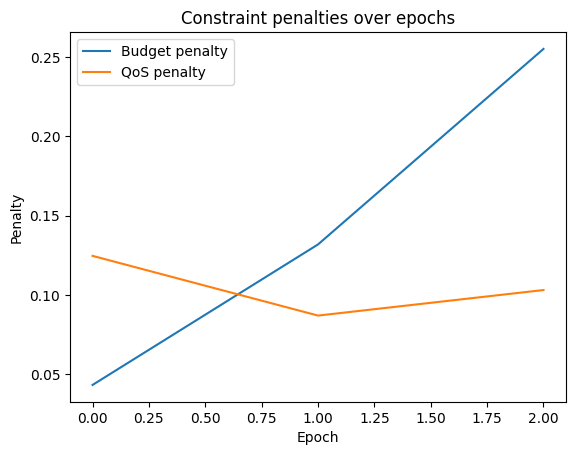

In [68]:
import matplotlib.pyplot as plt

df_logs = pd.DataFrame(logs)
x = range(EPOCHS)
plt.figure()
plt.plot(x, df_logs["loss"])
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

#Satisfaction
plt.figure()
plt.plot(x, df_logs["meanL"])
plt.xlabel("Epoch"); plt.ylabel("Mean Satisfaction")
plt.title("Satisfaction L over epochs")
plt.show()

#Penalty
plt.figure()
plt.plot(x, df_logs["budget"], label="Budget penalty")
plt.plot(x, df_logs["qos"], label="QoS penalty")
plt.xlabel("Epoch"); plt.ylabel("Penalty")
plt.title("Constraint penalties over epochs")
plt.legend()
plt.show()


In [75]:
@torch.no_grad()
def count_violations_on_loader(policy, loader):
    policy.eval()

    tot_users = tot_budget = tot_qos = 0
    num_batches = 0

    for batch, aux_list in loader:
        # forward toàn batch
        w_rx, p_f, a = policy(batch.x, batch.edge_index, batch.edge_weight)
        ptr = batch.ptr.detach().cpu().numpy()  # ranh giới từng scenario trong batch

        for s_idx, aux_i in enumerate(aux_list):
            lo, hi = int(ptr[s_idx]), int(ptr[s_idx+1])

            # cắt output theo scenario
            w_rx_i = w_rx[lo:hi]   # (N_i, K+1)
            p_f_i  = p_f[lo:hi]    # (N_i, F)
            a_i    = a[lo:hi]      # (N_i,)
            device = w_rx_i.device

            # move aux sang đúng device
            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in aux_i.items()}

            # unpack
            g_iL = aux_i["g_iL"]      # (N_i,)
            g_ik = aux_i["g_ik"]      # (N_i,K)
            Pmax = aux_i["Pmax"]      # (N_i,)
            Ci   = aux_i["Ci"]        # (N_i,)
            Lthr = aux_i["Lthr"]      # (N_i,)
            noise= aux_i["noise"]     # scalar
            SL   = aux_i["SL"]; SW = aux_i["SW"]; cprice = aux_i["cprice"]

            # quyết định mềm
            wL = w_rx_i[:, 0]         # (N_i,)
            wW = w_rx_i[:, 1:]        # (N_i,K)

            # kênh hữu ích & ma trận nhiễu mềm
            h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                      # (N_i,)
            Hbar  = wL.unsqueeze(1) * g_iL.unsqueeze(0) + wW @ g_ik.t()     # (N_i,N_i)
            Hbar.fill_diagonal_(0.0)

            # công suất & SINR
            P = a_i * Pmax                                                 # (N_i,)
            num = P * h_des
            SINR = torch.zeros_like(num)
            Fbands = p_f_i.size(1)
            for f in range(Fbands):
                S_f = p_f_i[:, f] * P                                      # (N_i,)
                denom = Hbar @ S_f + noise
                SINR += p_f_i[:, f] * (num / (denom + 1e-30))

            rate = torch.log2(1.0 + SINR)                                  # (N_i,)
            S_i  = SW + (SL - SW) * wL
            L_i  = S_i * rate

            # vi phạm
            budget_violation = F.relu(cprice * rate * wL - Ci)            # (N_i,)
            qos_violation    = F.relu(Lthr - L_i)                         # (N_i,)

            tot_users  += int(rate.numel())
            tot_budget += int((budget_violation > 0).sum().item())
            tot_qos    += int((qos_violation > 0).sum().item())

        num_batches += 1

    return {
        "users": tot_users,
        "budget_violations": tot_budget,
        "qos_violations": tot_qos,
        "budget_rate": tot_budget / max(tot_users, 1),
        "qos_rate": tot_qos / max(tot_users, 1),
        "batches": num_batches,
    }

In [76]:
summary = count_violations_on_loader(model, batches)
print(summary)

{'users': 5000, 'budget_violations': 2509, 'qos_violations': 1901, 'budget_rate': 0.5018, 'qos_rate': 0.3802, 'batches': 16}


## Constraint validation

# Thedual-objectiveproblem

In [ ]:
def _compute_per_scenario_metrics(w_rx, p_f, a, aux, tau: float = 0.2):
    """
    Tính metric cho 1 scenario (có grad):
      - L_i, rate          : (N,)
      - Q_soft_mean        : scalar (có grad), ~ P(L_i >= L_thr) với sigmoid làm surrogate
      - Q_hard_count, N_i  : để log (không cần grad)
      - pen_budget, pen_qos: scalar (có grad)
    """
    # unpack (đã đảm bảo ở đúng device trước khi gọi)
    g_iL = aux["g_iL"]      # (N,)
    g_ik = aux["g_ik"]      # (N,K)
    Pmax = aux["Pmax"]      # (N,)
    Ci   = aux["Ci"]        # (N,)
    Lthr = aux["Lthr"]      # (N,)
    noise= aux["noise"]     # scalar
    SL, SW = aux["SL"], aux["SW"]
    cprice = aux["cprice"]

    wL = w_rx[:, 0]         # (N,)
    wW = w_rx[:, 1:]        # (N,K)

    # Hữu ích & nhiễu "mềm"
    h_des = wL * g_iL + (wW * g_ik).sum(dim=1)                            # (N,)
    Hbar  = wL.unsqueeze(1) * g_iL.unsqueeze(0) + wW @ g_ik.t()           # (N,N)
    Hbar.fill_diagonal_(0.0)

    # Công suất & SINR
    P = a * Pmax                                                           # (N,)
    num = P * h_des
    SINR = torch.zeros_like(num)
    Fbands = p_f.size(1)
    for f in range(Fbands):
        S_f = p_f[:, f] * P                                                # (N,)
        denom = Hbar @ S_f + noise
        SINR += p_f[:, f] * (num / (denom + 1e-30))

    rate = torch.log2(1.0 + SINR)                                          # (N,)
    S_i  = SW + (SL - SW) * wL
    L_i  = S_i * rate                                                      # (N,)

    # Penalties (mềm)
    pen_budget = F.relu(cprice * rate * wL - Ci).mean()
    pen_qos    = F.relu(Lthr - L_i).mean()

    # Q mềm (có grad) & Q cứng (log)
    Q_soft_mean = torch.sigmoid((L_i - Lthr) / tau).mean()
    Q_hard_count = (L_i >= Lthr).sum().item()
    N_i = L_i.numel()

    return L_i, Q_soft_mean, Q_hard_count, N_i, pen_budget, pen_qos

In [ ]:
from torch.optim import Adam

class MTAdam:
    def __init__(self, params, lr=2e-3, weight_decay=1e-3, task_weights=None, eps=1e-8):
        """
        task_weights: list/tuple (w_L, w_Q) cộng thành 1. Mặc định 0.5/0.5.
        """
        self.opt = Adam(params, lr=lr, weight_decay=weight_decay, eps=eps)
        if task_weights is None:
            task_weights = (0.5, 0.5)
        assert abs(sum(task_weights) - 1.0) < 1e-6 and len(task_weights) == 2
        self.w = task_weights

    @torch.no_grad()
    def step_with_multitask_grads(self, model, losses):
        self.opt.zero_grad(set_to_none=True)

        # 2) tính grad cho từng task và snapshot
        grads_per_task = []
        for idx, L in enumerate(losses):
            # backward giữ graph cho task 1
            retain = (idx < len(losses) - 1)
            model.zero_grad(set_to_none=True)
            L.backward(retain_graph=retain)
            snapshot = []
            total_norm_sq = 0.0
            for p in model.parameters():
                if p.grad is None: 
                    snapshot.append(None)
                    continue
                g = p.grad.detach().clone()
                snapshot.append(g)
                total_norm_sq += g.pow(2).sum().item()
            norm = (total_norm_sq ** 0.5) + 1e-12
            grads_per_task.append((snapshot, norm))

        # 3) tổng hợp grad đã chuẩn hoá (weighted sum)
        model.zero_grad(set_to_none=True)
        for p_idx, p in enumerate(model.parameters()):
            agg = None
            for t_idx, (snap, nrm) in enumerate(grads_per_task):
                g_normed = None if snap[p_idx] is None else (snap[p_idx] / nrm)
                if g_normed is None: 
                    continue
                if agg is None:
                    agg = self.w[t_idx] * g_normed
                else:
                    agg = agg + self.w[t_idx] * g_normed
            if agg is not None:
                p.grad = agg  # đặt grad tổng

        # 4) cập nhật Adam một bước
        self.opt.step()


In [ ]:
def train_dual_MTAdam(
    policy: torch.nn.Module,
    batches,                      # list[(Batch, aux_list)]
    mtadam,                       # MTAdam(params, lr, weight_decay, task_weights=(wL,wQ))
    lambda_budget: float = 1.0,
    lambda_qos: float = 1.0,
    tau: float = 0.2,             # nhiệt độ cho Q mềm
    verbose: bool = False,
):
    """
    Train 1 epoch:
      - Mỗi batch: tính loss_L (maximize mean L, có penalty) & loss_Q (maximize Q mềm),
        rồi MTAdam trộn gradient và cập nhật 1 lần.
      - Trả về log trung bình theo batch: loss_L, loss_Q, meanL, Q_rate (cứng), pen_budget, pen_qos, batches.
    """
    device = next(policy.parameters()).device
    policy.train()

    ep_lossL = ep_lossQ = 0.0
    ep_meanL = ep_Qrate = 0.0
    ep_penB  = ep_penQ  = 0.0
    num_batches = 0

    for batch, aux_list in batches:
        batch = batch.to(device)

        # Forward toàn batch
        w_rx, p_f, a, _ = policy(batch.x, batch.edge_index, batch.edge_weight)
        ptr = batch.ptr.detach().cpu().numpy()  # ranh giới scenario trong batch

        # Gom theo scenario
        L_all = []
        Qsoft_list = []
        hard_total, users_total = 0, 0
        penB_list, penQ_list = [], []

        for s_idx, aux in enumerate(aux_list):
            lo, hi = int(ptr[s_idx]), int(ptr[s_idx+1])

            # move aux_i lên đúng device (aux lưu CPU là đúng)
            aux_i = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in aux.items()}

            L_i, Q_soft_mean, Q_hard_cnt, N_i, penB, penQ = _compute_per_scenario_metrics(
                w_rx[lo:hi], p_f[lo:hi], a[lo:hi], aux_i, tau=tau
            )
            L_all.append(L_i)
            Qsoft_list.append(Q_soft_mean)
            hard_total  += Q_hard_cnt
            users_total += N_i
            penB_list.append(penB); penQ_list.append(penQ)

        # Tổng hợp batch
        if len(L_all) == 0:
            continue  # batch rỗng (hiếm khi), bỏ qua
        L_all      = torch.cat(L_all, dim=0)
        meanL      = L_all.mean()
        Q_soft     = torch.stack(Qsoft_list).mean()           # có grad
        Q_hard_rate= hard_total / max(users_total, 1)         # để log

        pen_budget = torch.stack(penB_list).mean()
        pen_qos    = torch.stack(penQ_list).mean()

        # Hai loss nhiệm vụ
        loss_L = -meanL + lambda_budget * pen_budget + lambda_qos * pen_qos
        loss_Q = -Q_soft

        # MTAdam update (chuẩn hoá grad từng task rồi trộn theo trọng số)
        mtadam.step_with_multitask_grads(policy, [loss_L, loss_Q])

        # Log theo batch
        ep_lossL += float(loss_L.item())
        ep_lossQ += float(loss_Q.item())
        ep_meanL += float(meanL.item())
        ep_Qrate += float(Q_hard_rate)
        ep_penB  += float(pen_budget.item())
        ep_penQ  += float(pen_qos.item())
        num_batches += 1

        if verbose:
            print(f"  batch {num_batches:03d} | meanL {meanL.item():.4f} | "
                  f"Q% {100*Q_hard_rate:.2f} | Ls {loss_L.item():.4f} | "
                  f"Qs {loss_Q.item():.4f} | penB {pen_budget.item():.4f} | penQ {pen_qos.item():.4f}")

    # Trung bình theo batch
    return {
        "loss_L":   ep_lossL / max(num_batches, 1),
        "loss_Q":   ep_lossQ / max(num_batches, 1),
        "meanL":    ep_meanL / max(num_batches, 1),
        "Q_rate":   ep_Qrate / max(num_batches, 1),   # % user thỏa (cứng) để theo dõi
        "pen_budget": ep_penB / max(num_batches, 1),
        "pen_qos":    ep_penQ / max(num_batches, 1),
        "batches":  num_batches,
    }

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy = PolicyGCN(in_dim=7, hidden=128, K=cfg.K, Fs=cfg.Fs).to(device)

mtadam = MTAdam(policy.parameters(), lr=2e-3, weight_decay=1e-3,
                task_weights=(0.3, 0.7)) 


logs = []
EPOCHS = 100
for ep in range(1, EPOCHS+1):
    ep_log = train_dual_MTAdam(
        policy, batches, mtadam,
        lambda_budget=10.0, lambda_qos=10.0,
        return_batch_means=False
    )
    ep_log["epoch"] = ep
    logs.append(ep_log)
    print(f"[Ep {ep:03d}] meanL={ep_log['meanL']:.4f} | Q%={100*ep_log['Q_rate']:.2f}% "
          f"| loss_L={ep_log['loss_L']:.4f} | loss_Q={ep_log['loss_Q']:.4f} "
          f"| pen(B)={ep_log['pen_budget']:.4f} | pen(Q)={ep_log['pen_qos']:.4f}")


[Ep 001] meanL=1.0385 | Q%=44.55% | loss_L=0.4598 | loss_Q=-0.5416 | pen(B)=0.0216 | pen(Q)=0.1282
[Ep 002] meanL=1.6259 | Q%=71.77% | loss_L=-0.7017 | loss_Q=-0.7443 | pen(B)=0.0331 | pen(Q)=0.0594
[Ep 003] meanL=2.4424 | Q%=89.11% | loss_L=-1.8494 | loss_Q=-0.8838 | pen(B)=0.0404 | pen(Q)=0.0189
[Ep 004] meanL=3.2594 | Q%=94.45% | loss_L=-2.8035 | loss_Q=-0.9321 | pen(B)=0.0354 | pen(Q)=0.0102
[Ep 005] meanL=3.8907 | Q%=95.44% | loss_L=-3.4005 | loss_Q=-0.9428 | pen(B)=0.0411 | pen(Q)=0.0079
[Ep 006] meanL=4.0525 | Q%=95.94% | loss_L=-3.5322 | loss_Q=-0.9468 | pen(B)=0.0449 | pen(Q)=0.0071
[Ep 007] meanL=4.1685 | Q%=96.30% | loss_L=-3.6365 | loss_Q=-0.9499 | pen(B)=0.0466 | pen(Q)=0.0066
[Ep 008] meanL=4.2801 | Q%=96.48% | loss_L=-3.8055 | loss_Q=-0.9518 | pen(B)=0.0409 | pen(Q)=0.0066
[Ep 009] meanL=4.3698 | Q%=96.70% | loss_L=-3.9290 | loss_Q=-0.9537 | pen(B)=0.0381 | pen(Q)=0.0060
[Ep 010] meanL=4.4291 | Q%=97.04% | loss_L=-4.0328 | loss_Q=-0.9555 | pen(B)=0.0340 | pen(Q)=0.0057
[

In [77]:
summary2 = count_violations_on_loader(policy, batches)
print(summary2)

{'users': 5000, 'budget_violations': 3000, 'qos_violations': 103, 'budget_rate': 0.6, 'qos_rate': 0.0206, 'batches': 16}
